<a href="https://colab.research.google.com/github/bahmanravaei/Ising-oneDimensionalSequential/blob/main/Ising_Model_with_replica_exchange_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boltzmann

In [2]:
# Function to calculate the energy of the system
def calculate_energy(replica, spins, J):
    tempSpins=spins[replica]
    energy = -J * np.sum(tempSpins * np.roll(tempSpins, 1, axis=0) + tempSpins * np.roll(tempSpins, 1, axis=1))
    return energy

In [3]:
# Function to perform Metropolis update for a single spin
def metropolis_update(replica, spins, beta, J):
    i, j = np.random.randint(0, spins.shape[1]), np.random.randint(0, spins.shape[2])
    delta_energy = 2 * J * spins[replica, i, j] * (spins[replica, (i - 1) % spins.shape[1], j] + spins[replica, (i + 1) % spins.shape[2], j] +
                                          spins[replica, i, (j - 1) % spins.shape[2]] + spins[replica, i, (j + 1) % spins.shape[2]])

    if delta_energy < 0 or np.random.rand() < np.exp(-beta * delta_energy):
        spins[replica, i, j] *= -1

In [4]:

# Function to run REMC simulation for the Ising model
def run_remc_simulation(lattice_size, num_replicas, num_steps, temperatures):
    spins = np.random.choice([-1, 1], size=(num_replicas ,lattice_size, lattice_size))
    J = 1.0  # Interaction strength
    exchange_attempts = 100  # Number of exchange attempts between neighboring replicas

    energies = np.zeros((num_replicas, num_steps))
    magnetizations = np.zeros((num_replicas, num_steps))

    changeFlag = 0
    for step in range(num_steps):
        for replica in range(num_replicas):
            beta = 1 / temperatures[replica]
            for _ in range(lattice_size ** 2):
                metropolis_update(replica, spins, beta, J)

            energies[replica, step] = calculate_energy(replica, spins, J)
            magnetizations[replica, step] = np.sum(spins[replica])

        # Replica exchange attempts
        if step % exchange_attempts == 0:
            delta_beta = np.zeros(num_replicas)
            delta_energy = np.zeros(num_replicas)

            for replica in range(0, num_replicas - 1):
                delta_beta[replica] = temperatures[replica] - temperatures[replica + 1]
                delta_energy[replica] = (1 / temperatures[replica] - 1 / temperatures[replica + 1]) * (
                        energies[replica, step] - energies[replica + 1, step])


            #tempSpins=np.copy(spins)

            for replica in range(0, num_replicas - 1):

                if changeFlag == 0 and (delta_energy[replica] > 0 or np.random.rand() < np.exp(delta_beta[replica] * delta_energy[replica])):
                    changeFlag = 1
                    #print("Exchange "+ str(replica) + " <-> " + str(replica+1))
                    spins[replica, :], spins[replica + 1, :] = spins[replica + 1, :], spins[replica, :]
                    energies[replica, step], energies[replica + 1, step] = energies[replica + 1, step], energies[replica, step]
                    magnetizations[replica, step], magnetizations[replica + 1, step] = magnetizations[replica + 1, step], \
                                                                                    magnetizations[replica, step]
                else:
                    changeFlag = 0

    return energies, magnetizations


In [5]:
# Parameters
lattice_size = 25
num_replicas = 8
num_steps = 1000
temperatures = np.linspace(1, 4, num_replicas)

In [6]:
# Run REMC simulation
energies, magnetizations = run_remc_simulation(lattice_size, num_replicas, num_steps, temperatures)


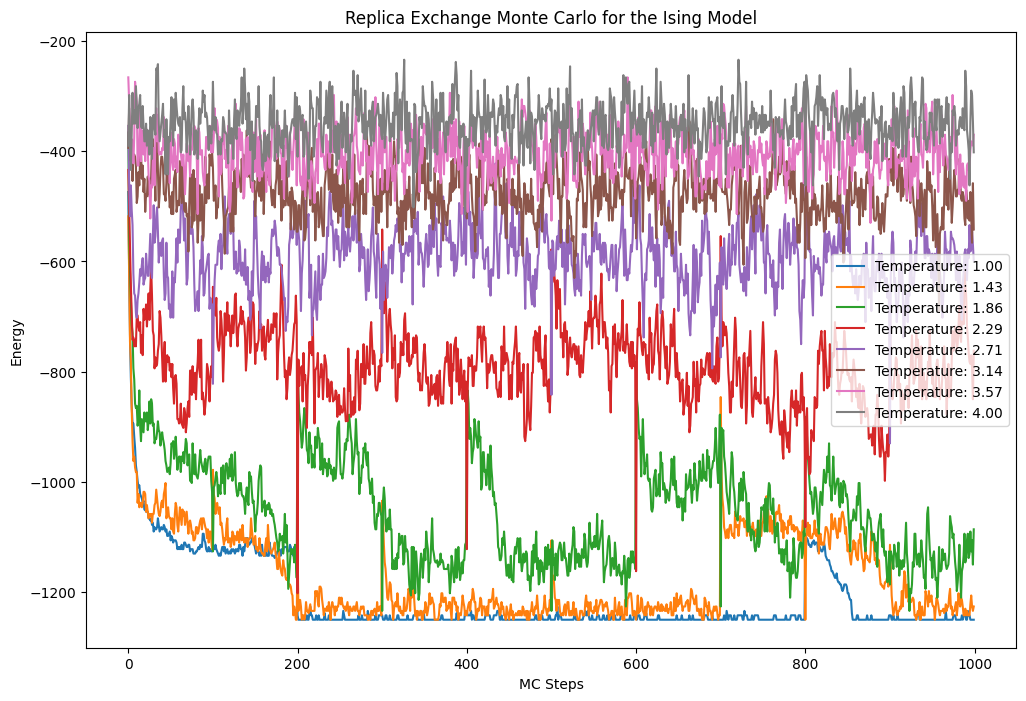

In [7]:

# Plot results (Energies)
plt.figure(figsize=(12, 8))
for replica in range(num_replicas):
    plt.plot(energies[replica, :], label=f'Temperature: {temperatures[replica]:.2f}')

plt.title('Replica Exchange Monte Carlo for the Ising Model')
plt.xlabel('MC Steps')
plt.ylabel('Energy')
plt.legend()
plt.show()


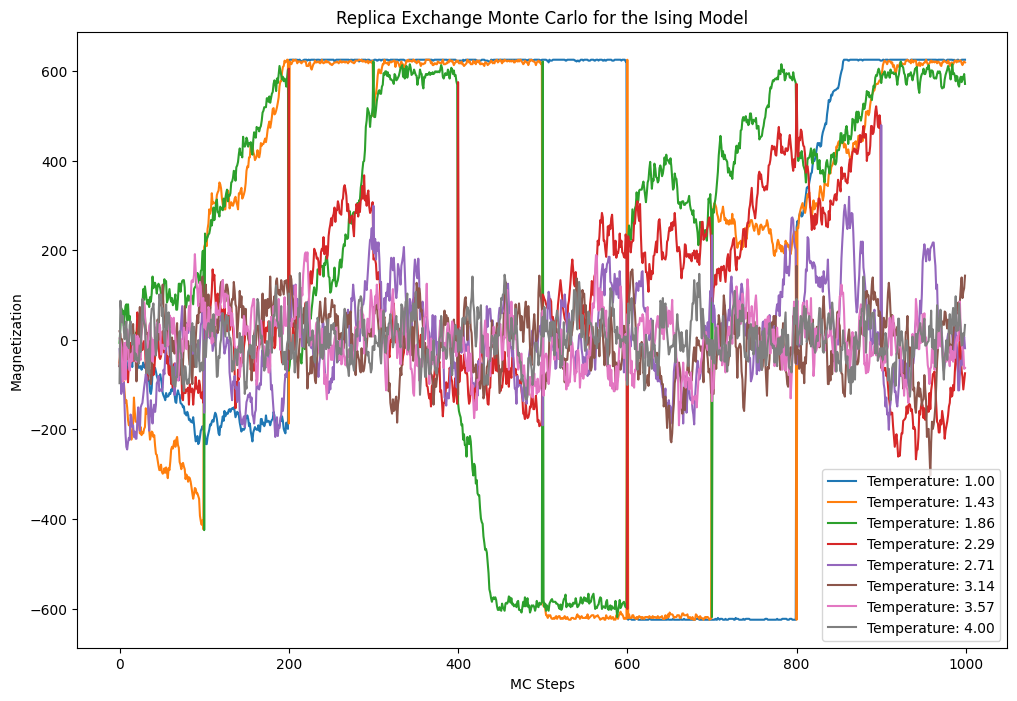

In [8]:
# Plot results (Magnetizations)
plt.figure(figsize=(12, 8))
for replica in range(num_replicas):
    plt.plot(magnetizations[replica, :], label=f'Temperature: {temperatures[replica]:.2f}')

plt.title('Replica Exchange Monte Carlo for the Ising Model')
plt.xlabel('MC Steps')
plt.ylabel('Magnetization')
plt.legend()
plt.show()